# 主要是框架内部的处理类

写一个类

## 数据预处理部分

In [1]:
# 重新加载模块
%load_ext autoreload
%autoreload 2
from utils.DataPreProcessor_0605 import DataPreProcessor, Group 

sensitive_names = ["sex"]
processor = DataPreProcessor(
    data_path="../input/adult.csv", 
    sensitive_names=sensitive_names,
    label="income",
    label_mapper={"<=50K":0, ">50K":1}
)

{(0.703665851855809,): ('Male',), (-1.4211290733558493,): ('Female',)}


[16:13:38] INFO     数据集处理完毕， 遍历 xxx.grouped                                   ]8;id=127786;file://d:\Dropbox\Projects\joyful-pandas\exp_v2\utils\DataPreProcessor_0605.py\DataPreProcessor_0605.py]8;;\:]8;id=673704;file://d:\Dropbox\Projects\joyful-pandas\exp_v2\utils\DataPreProcessor_0605.py#46\46]8;;\
                    查看数据，每个单元是Group(scale_name, origin_name , X, y)                                      

## 模型训练与预测

In [2]:
import xgboost

# 训练集、测试集和敏感属性
X_train = processor.X_train_label_scale
y_train = processor.y_train
X_test = processor.X_test_label_scale
y_test = processor.y_test
sensitive_indexes = processor.X_test[sensitive_names]

# 模型训练 
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [3]:
from utils.FairMetric_0605 import FairMetric

fm = FairMetric("XGBClassifier-baseline", y_test, y_pred, sensitive_features=sensitive_indexes)
fm.metrics

准确度(1)      0.871635
精确度(1)      0.772044
召回率(1)      0.658547
f1分数(1)     0.710793
AUC分数(1)    0.798650
DP差异(0)     0.186382
DP比率(1)     0.298818
EO差异(0)     0.069172
EO比率(1)     0.215589
Name: XGBClassifier-baseline, dtype: float64

In [4]:
import shap
import pandas as pd

def get_shapley_values(X, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shapley_values = pd.DataFrame(data=shap_values.values, columns=X.columns, index=X.index)
    return shapley_values
shapley_values = get_shapley_values(processor.X_train_label_scale, model)
shapley_values.head()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
19749,0.494813,0.026526,-0.213601,-0.045938,-0.376381,0.463009,-0.021303,0.509124,0.029389,0.075267,-0.155306,-0.064937,-0.049951,0.023530
1216,0.500095,-0.002224,-0.207415,-0.189268,-0.220711,-0.490526,0.123010,-0.486618,0.022525,-0.381510,-0.132950,-2.609746,-0.836442,0.001223
27962,-0.201751,0.024517,-0.071968,0.033012,0.767833,0.451731,-0.474881,0.655555,-0.308522,0.038492,-0.198145,-0.099592,-0.055016,-0.609599
23077,-1.826280,0.035445,-0.060712,-0.215791,0.111234,-1.321697,0.256745,-0.766208,-0.008487,0.073554,-0.147942,-0.066919,-0.916901,0.023987
10180,-0.303005,0.052490,0.285900,-0.134943,-0.460785,0.547875,0.057780,1.367415,0.068808,-0.171300,-0.102331,-0.071025,-1.030011,0.015273


## SHAP-FAIR 框架

![图片](./assets/2024-05-27-流程图.drawio.svg)

In [5]:
# 挑选一个 group，以男性举例
handle_group: Group = processor.groups[1]
X: pd.DataFrame = handle_group.X
y: pd.Series = handle_group.y
handle_group.origin_name, X.shape, y.shape, sensitive_indexes

(('Male',),
 (15244, 14),
 (15244,),
           sex
 14160    Male
 27048    Male
 28868  Female
 5667     Male
 7827   Female
 ...       ...
 32476  Female
 21100    Male
 27131    Male
 25526    Male
 21385    Male
 
 [9769 rows x 1 columns])

### 个体间-SHAP距离

Shapley Distance between Individual and Individual

$$
{\rm SDII}(F, \phi_i, \phi_j) = \sum_{f\in F}^f|\phi_i^f-\phi_j^f|
$$

### 个体与组-SHAP距离 

Shapley Distance between Individual and Group

$$
{\rm SDIG}(F, \phi_i, \phi) = \frac 1{m-1}\sum_{\phi_j \in \phi}^{\phi}{\rm SDII}(F, \phi_i, \phi_j)
$$

In [6]:
from utils.ShapFairFrameGroup_0606 import ShapFairGroup

In [7]:
handle_group: Group = processor.groups[1]
X: pd.DataFrame = handle_group.X
y: pd.Series = handle_group.y
handle_group.origin_name, X.shape, y.shape, sensitive_indexes
shapley_values_X = shapley_values.loc[X.index]
sfg = ShapFairGroup(X, y, shapley_values_X, sensitive_names)
sfg.sdgg("cache/2024-06-06-Male-test.csv")
sfg.get_candidates_fair_X('sex', 0.1)
sfg.get_df_neighbors_by_knn()
sfg.get_unfair_idx()
male_unfair_idx = sfg.unfair_idx.values

读取缓存:  cache/2024-06-06-Male-test.csv
统计: 大于 threshold 379 个, 小于 14865 个
候选者 379 个, 不公平者 99 个, 比例 26.12%


--------------------------------------------------
处理 group Female
读取缓存:  cache/2024-06-06-Female-v1.csv


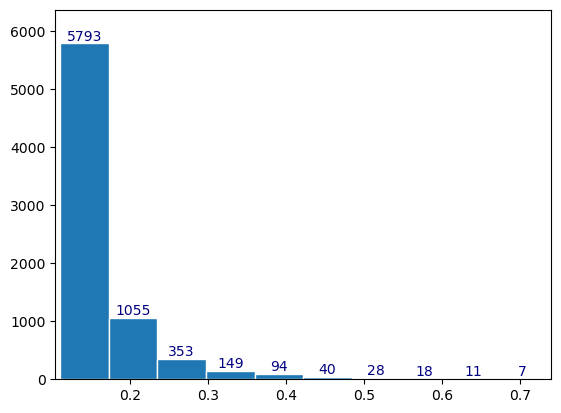

统计: 大于 threshold 577 个, 小于 6971 个
候选者 577 个, 不公平者 21 个, 比例 3.64%
--------------------------------------------------
处理 group Male
读取缓存:  cache/2024-06-06-Male-v1.csv


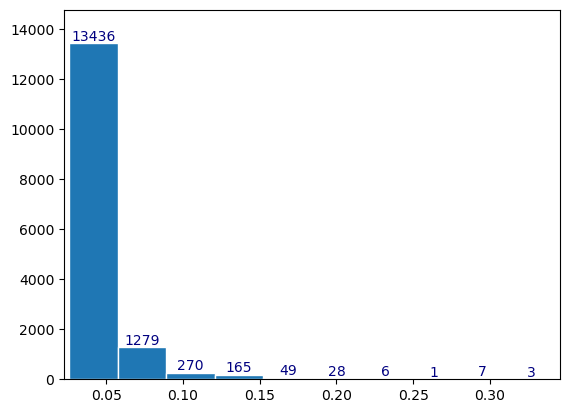

统计: 大于 threshold 47 个, 小于 15197 个
候选者 47 个, 不公平者 17 个, 比例 36.17%


In [8]:
from datetime import datetime
import logging
logging.basicConfig(level=logging.INFO)

class ShapFairFramework:
    def __init__(self, groups, sensitive_names) -> None:
        self.groups = groups
        self.sensitive_names = sensitive_names

    def run(self):
        for group in self.groups:
            self.handle_group(group)

    def handle_group(self, group: Group, *, suffix="v1", threshold):
        print("-"*50)
        print("处理 group", "".join(group.origin_name))

        X: pd.DataFrame = group.X
        y: pd.Series = group.y
        origin_name = "".join(group.origin_name)

        shapley_values_X = shapley_values.loc[X.index]
        sfg = ShapFairGroup(X, y, shapley_values_X, self.sensitive_names)
        date = datetime.today().strftime("%Y-%m-%d")
        sfg.sdgg(f"cache/{date}-{origin_name}-{suffix}.csv")
        sfg.show_sigg_hist("sex")
        # todo 硬编码
        sfg.get_candidates_fair_X("sex", threshold)
        sfg.get_df_neighbors_by_knn()
        sfg.get_unfair_idx()
        return sfg.unfair_idx.values

groups = processor.groups
sff = ShapFairFramework(groups, sensitive_names=sensitive_names)
female_unfair_idxs = sff.handle_group(groups[0], threshold=0.25)
male_unfair_idxs = sff.handle_group(groups[1], threshold=0.18)

In [9]:
logging.getLogger().getEffectiveLevel()
logging.NOTSET

0

In [10]:
female_unfair_idxs, len(female_unfair_idxs)

(array([ 3213, 29211,    31, 25311, 23900,  4965, 18907, 22923, 14568,
           22,    51, 28994,  2149, 22733, 21749,   154, 15472, 18196,
        30381, 20643,  2368], dtype=int64),
 21)

In [11]:
import numpy as np
unfair_idx = np.r_[female_unfair_idxs, male_unfair_idxs]
unfair_idx, len(unfair_idx)

(array([ 3213, 29211,    31, 25311, 23900,  4965, 18907, 22923, 14568,
           22,    51, 28994,  2149, 22733, 21749,   154, 15472, 18196,
        30381, 20643,  2368, 13857,  5088, 28722, 28753, 13881, 26353,
        22709,  6999, 15197, 17952, 28255, 26996, 24802, 32142, 28011,
         3173,   197], dtype=int64),
 38)

In [12]:
y_new = y_train.copy()
y_new[unfair_idx] = 1 - y_new[unfair_idx]
y_new.shape
(y_new != y_train).value_counts()

income
False    22754
True        38
Name: count, dtype: int64

In [13]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_new)
y_pred = model.predict(X_test)

In [14]:
fm_new = FairMetric("XGBClassifier-new", y_test, y_pred, sensitive_features=sensitive_indexes)
fm_new.metrics

准确度(1)      0.872658
精确度(1)      0.781603
召回率(1)      0.650000
f1分数(1)     0.709753
AUC分数(1)    0.796396
DP差异(0)     0.186152
DP比率(1)     0.285725
EO差异(0)     0.082904
EO比率(1)     0.204330
Name: XGBClassifier-new, dtype: float64

In [15]:
fm.metrics

准确度(1)      0.871635
精确度(1)      0.772044
召回率(1)      0.658547
f1分数(1)     0.710793
AUC分数(1)    0.798650
DP差异(0)     0.186382
DP比率(1)     0.298818
EO差异(0)     0.069172
EO比率(1)     0.215589
Name: XGBClassifier-baseline, dtype: float64